# All plots in one notebook

I want to have all plots in one notebook bc I can make changes quicker (e.g. style etc) and only run one notebook to have all plots ready!

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

In [2]:
from cycler import cycler
import matplotlib

# Set the color cycle
#plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#c7463d', '#ffad08', '#6f73b0', '#56b4e9', '#4c6e3d', '#c47ca2', '#f5f575']))
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))

# Configure Matplotlib to use LaTeX fonts
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"

# Set font sizes
matplotlib.rcParams.update(
    {
        "font.size": 16,  # General font size
    }
)

In [3]:
save_status = False # save all histograms!

# Hbb fast vs full sim (3 plots)

In [4]:
#path_fullsim = "/home/saaumill/FullSimTagger/src/Hbb_fullsim_tree.root"
path_fullsim = "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_input_hadded/final-fullsim-inputNN/Hbb_largedata_fraction_fullsim_input_NN.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/samples_v5/CLD_240/stage2_Hbb.root"

file_fu = uproot.open(path_fullsim)
tree_fu = file_fu["tree;1"]

file_fa = uproot.open(path_fastsim)
tree_fa = file_fa["tree;1"]


df_fa = tree_fa.arrays(library="np", entry_start=0, entry_stop=250000) #entry_start=0, entry_stop=200, 
df_fu = tree_fu.arrays(library="np", entry_start=0, entry_stop=250000)

# 3min on fcc03 ironic

In [5]:
def get_index_charged_particles(df, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    if df == 'fa':
        types = df_fa['pfcand_type']
        if ptype=='cpart':
            num = [0]
        elif ptype=='npart':
            num = [130]
        elif ptype=='photon':
            num = [22]
    elif df == 'fu':
        types = df_fu['pfcand_type']
        if ptype=='cpart':
            num = [-211, -13, -11, 11, 13, 211] 
        elif ptype=='npart':
            num = [2112]
        elif ptype=='photon':
            num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [6]:
def get_value_highest_energy_particle(df, k=3, ptype='cpart', debug=False):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fa':
        particles_e = df_fa['pfcand_e']
        mask_chad = get_index_charged_particles('fa', ptype=ptype)
    elif df == 'fu':
        particles_e = df_fu['pfcand_e']
        mask_chad = get_index_charged_particles('fu', ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
        if debug and i==1:
            print("part_e: ", part_e)
            print("mask: ", mask)
            print("ind: ", ind)
            print("index_map: ", index_map)
            print("c_index: ", c_index)
            print("sorted_c_index: ", sorted_c_index)
    return index_charged

In [7]:
# these are lists because there might not always be 3 charged particles
index_charged_3E_fu = get_value_highest_energy_particle("fu")
index_charged_3E_fa = get_value_highest_energy_particle("fa")
# these are lists because there might not always be 3 neutral particles
index_neutral_3E_fu = get_value_highest_energy_particle("fu", ptype='npart')
index_neutral_3E_fa = get_value_highest_energy_particle("fa", ptype='npart')

In [8]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [9]:
def plot_z0_forNote(save=False, path=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True)

    bins=60
    r = {'pfcand_dz': [-1, 1]}
    key = 'pfcand_dz'
    a_list = get_chad_elements(df_fa[key], index_charged_3E_fa)
    b_list = get_chad_elements(df_fu[key], index_charged_3E_fu)

    ri = r[key] if r != None else None
    i = 0
        
    a = a_list[i]
    b = b_list[i]

    if ri == None:
        combined_min = min(a.min(), b.min())
        combined_max = max(a.max(), b.max())
        combined_range = (combined_min, combined_max)
    else:
        combined_range = ri
        # make overflow bins
        a = np.clip(a, *combined_range)
        b = np.clip(b, *combined_range)
    
    #ax.set_title("leading charged jet constituents")
    ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'Fast sim', density=True)
    ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'Full sim', density=True)
    ax.legend()
    ax.grid()
    ax.set_xlabel(r'$z_0$ (mm)')
    #plt.tight_layout()
    if save:
        if path==None:
            path = './plots-for-FCC-note/fastvsfullSimCLD-z0-leading-cpart.pdf'
        plt.savefig(path)
    plt.show()

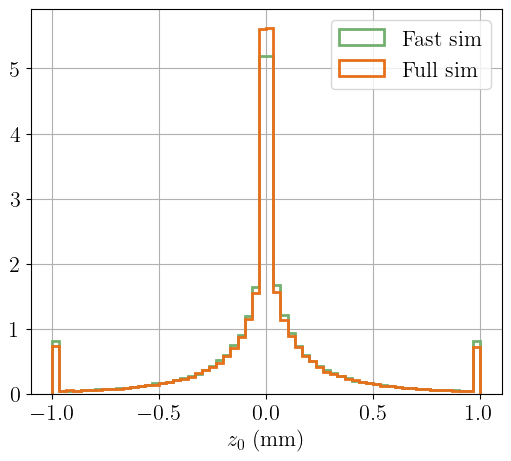

In [10]:

plot_z0_forNote(save=save_status)

In [11]:


def format_func(value, tick_number):
    # Value is in radians, convert it to multiples of pi
    N = int(np.round(2 * value / np.pi))  # Multiples of pi/2
    if N == 0:
        return r"$0$"
    elif N == 1:
        return r"$\frac{\pi}{2}$"
    elif N == -1:
        return r"$-\frac{\pi}{2}$"
    elif N == 2:
        return r"$\pi$"
    elif N == -2:
        return r"$-\pi$"
    else:
        # Handle cases beyond -2*pi and 2*pi, though they might not appear
        return r"${0}\pi$".format(N/2 if N % 2 == 0 else f'{N}/2')

def plot_phirel_forNote(save=False, path=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4.5), constrained_layout=True)
    
    bins=60
    r = {'pfcand_phirel': None}
    key = 'pfcand_phirel'
    a_list = get_chad_elements(df_fa[key], index_neutral_3E_fa)
    b_list = get_chad_elements(df_fu[key], index_neutral_3E_fu)

    ri = r[key] if r != None else None
    i = 0
        
    a = a_list[i]
    b = b_list[i]

    if ri == None:
        combined_min = min(a.min(), b.min())
        combined_max = max(a.max(), b.max())
        combined_range = (combined_min, combined_max)
    else:
        combined_range = ri
        # make overflow bins
        a = np.clip(a, *combined_range)
        b = np.clip(b, *combined_range)
    
    #ax.set_title("leading neutral hadronic jet constituents")
    ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'Fast sim', density=True)
    ax.hist(b, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=f'Full sim', density=True)
    ax.legend()
    ax.grid()
    ax.set_xlabel(r'$\phi_\mathrm{rel}$ (rad)')

    # Set ticks in factors of pi
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi / 2))  # Major ticks every pi/2
    ax.xaxis.set_minor_locator(MultipleLocator(base=np.pi / 4))  # Minor ticks every pi/4
    ax.xaxis.set_major_formatter(FuncFormatter(format_func))

    #plt.tight_layout()
    if save:
        if path==None:
            path = './plots-for-FCC-note/fastvsfullSimCLD-relphi-leading-nhad.pdf'
        plt.savefig(path)
    plt.show()

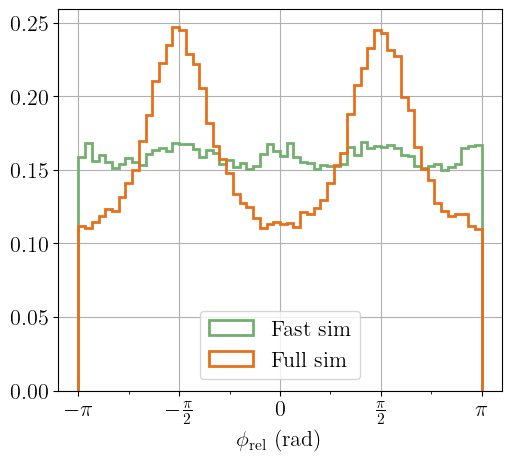

In [12]:
plot_phirel_forNote(save=save_status)

In [13]:
def hist_forNote(save=False):
    keys = ['jet_nconst',
        'jet_ngamma',
        'jet_nel',
        'jet_nmu',
        'jet_nchad',
        'jet_nnhad']
    labels = ['\# constituents',
        '\# photons',
        '\# electrons',
        '\# muons',
        '\# charged hadrons',
        '\# neutral hadrons']
    r = {'jet_nconst': [0, 80],
        'jet_ngamma': [0, 45],
        'jet_nel': [0, 6],
        'jet_nmu': [0, 4],
        'jet_nchad': [0, 35],
        'jet_nnhad': [0, 15]}
    n = 2
    k = 3
    fig, axs = plt.subplots(n, k, figsize=(10, 4.5), constrained_layout=True)
    
    for i, ax in enumerate(axs.flat):
        ax.grid()
        ax.set_xlabel(labels[i])

        # Get range for current key
        combined_range = r[keys[i]]

        # Prepare data with overflow handling
        fa = np.clip(df_fa[keys[i]], *combined_range)
        fu = np.clip(df_fu[keys[i]], *combined_range)

        # Plot histograms with overflow
        ax.hist(fa, bins=r[keys[i]][1], range=combined_range, label='Fast sim', histtype='step', linewidth=2.0, density=True)
        ax.hist(fu, bins=r[keys[i]][1], range=combined_range, label='Full sim', histtype='step', linewidth=2.0, density=True)

        if i == 3:
            ax.legend()
    
    #plt.tight_layout()
    if save:
        path = './plots-for-FCC-note/fastvsfullSim_Hbb-multiplicities.pdf'
        plt.savefig(path)
    plt.show()


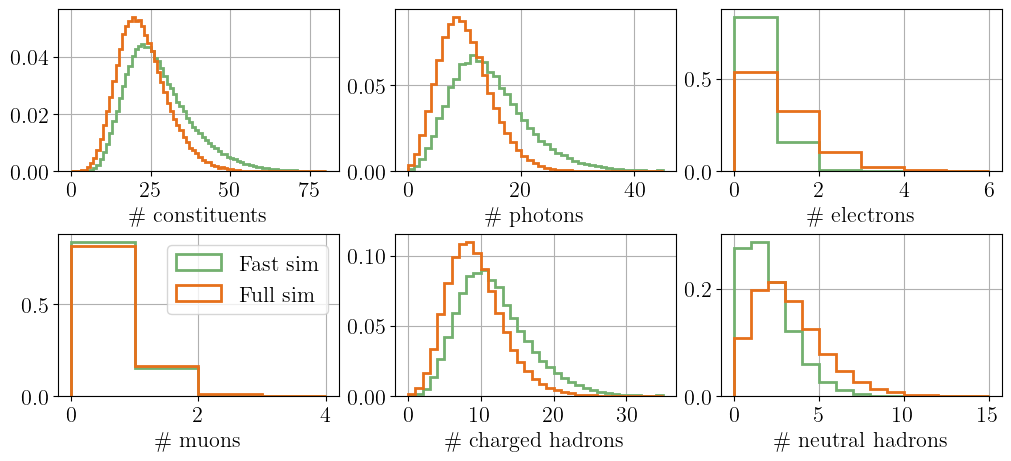

In [14]:
hist_forNote(save=save_status)


In [15]:
del file_fu, tree_fu, file_fa, tree_fa, df_fa, df_fu
gc.collect()

34711

# Lost tracks in full sim

In [16]:
def load_data(file_name, entry_stop=25000):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=entry_stop) #entry_stop=1000000)
    return data

In [17]:
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_trackPFOcheck/hadded_forNote"
dic = {
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root", entry_stop=250000)
    dic[process] = data

In [18]:
# Normalize function
def normalize_hist(data, ref_counts, bins, range):
    counts, _ = np.histogram(data, bins=bins, range=range, density=False)
    # Avoid division by zero by using np.where
    normalized_counts = np.where(ref_counts > 0, counts / ref_counts, 0)
    return normalized_counts


In [19]:
def subplot_pfo_div(j, ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l, Htype, ind_ptype):
    d=False
    ranges = [[0, 50], [0, 3.14]]
    xlabels = [r"$p$ (GeV)", r"$\theta$ (rad)"]
    num_bins = 60
    for i, obs in enumerate(["momentum", "theta"]):
        if Htype=="gg" and (l=="e" or l=="muon"):
            ranges[0] = [0, 15]
        # Logarithmic binning for "momentum"
        if obs == "momentum":
            bins = np.logspace(np.log10(ranges[i][0]+1e-1), np.log10(ranges[i][1]), num_bins)
            ax[i].set_xscale("log")
        else:
            bins = np.linspace(ranges[i][0], ranges[i][1], num_bins)
        # Calculate the reference histogram counts
        ref_counts, bin_edges = np.histogram(np.concatenate(dic[Htype][obs])[ind_ptype], bins=bins, range=ranges[i], density=d)

        # Normalize each histogram data
        track_data = np.concatenate(dic[Htype][obs])[i_pfo_track]
        neutral_data = np.concatenate(dic[Htype][obs])[i_pfo_neutral]
        loss_data = np.concatenate(dic[Htype][obs])[i_pfo_loss]
        
        normalized_track = normalize_hist(track_data, ref_counts, bins, range=ranges[i])
        normalized_neutral = normalize_hist(neutral_data, ref_counts, bins, range=ranges[i])
        normalized_loss = normalize_hist(loss_data, ref_counts, bins, range=ranges[i])

        # Plot normalized histograms
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers for plotting
        effi = eff(Htype, ind_ptype)
        ax[i].plot(bin_centers, normalized_track, drawstyle='steps-mid', linewidth=2.0, label=f"track ({effi[2]}\%)")
        ax[i].plot(bin_centers, normalized_neutral, drawstyle='steps-mid', linewidth=2.0, label=f"neutral ({effi[1]}\%)")
        ax[i].plot(bin_centers, normalized_loss, drawstyle='steps-mid', linewidth=2.0, label=f"loss ({effi[0]}\%)")
        ax[i].grid()
        if i==0:
            ax[i].legend()
        ax[i].set_xlabel(xlabels[i])
        ax[i].set_ylabel("PFO track efficiency")
        ax[i].set_ylim(0, 1.01)

In [20]:
def plot_Hbb_losttracks_chad(save=False, path=None):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)
    Htype="bb"

    ind_chad = np.where(abs(np.concatenate(dic[Htype]["mcpid"])) == 211)

    ind_pfo_track = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 2)
    ind_pfo_neutral = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 1)
    ind_pfo_loss = np.where(np.concatenate(dic[Htype]["mc_pfo_type"]) == 0)

    i_pfo_track = np.intersect1d(ind_pfo_track, ind_chad)
    i_pfo_neutral = np.intersect1d(ind_pfo_neutral, ind_chad)
    i_pfo_loss = np.intersect1d(ind_pfo_loss, ind_chad)

    _, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"]), return_counts=True)
    fig.suptitle(r"MC charged hadrons ($H \rightarrow b \bar{b}$)")
    print(f"({np.round(count/np.sum(count)*100, 2)[2]} % PFO track eff.)")

    print("average energy lost per event due to missing charged hadrons: ", np.round(np.sum(np.concatenate(dic[Htype]["energy"])[i_pfo_loss])/len(dic[Htype]["energy"]), 3), " GeV")

    # the plot
    subplot_pfo_div(2,ax, i_pfo_track, i_pfo_neutral, i_pfo_loss, l="chad", Htype=Htype, ind_ptype=ind_chad)

    if save:
        if path==None:
            path = './plots-for-FCC-note/fullSimCLD-losttracks_Hbb_chad_30perc-minfrac.pdf'
        plt.savefig(path)
    plt.show()

In [21]:
def eff(Htype, ind):
    values, count = np.unique(np.concatenate(dic[Htype]["mc_pfo_type"])[ind], return_counts=True)
    #print("percentage of loss, neutral, track: ", np.round(count/np.sum(count)*100, 2), "%")
    if 0 not in values:
        count = np.insert(count, 0, 0)
    return np.round(count/np.sum(count)*100, 2)

(87.6 % PFO track eff.)
average energy lost per event due to missing charged hadrons:  0.906  GeV


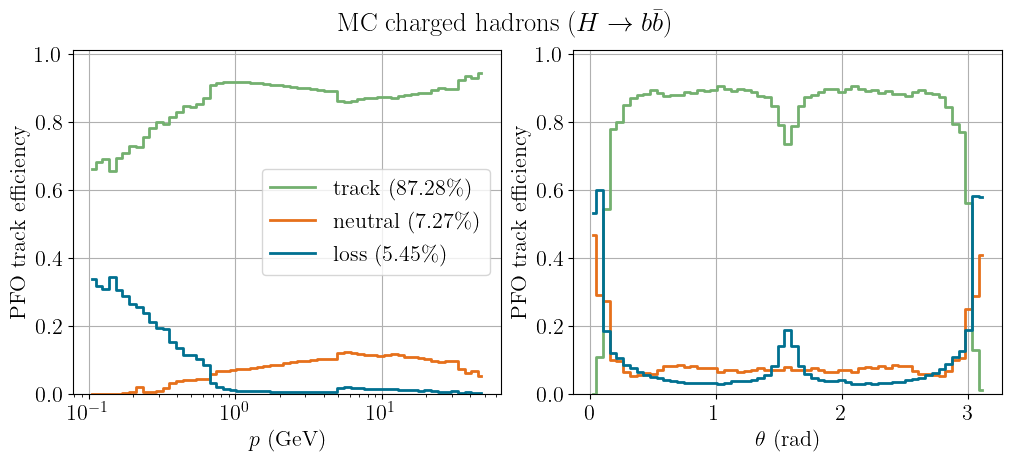

In [22]:
plot_Hbb_losttracks_chad(save=save_status)

In [23]:
del dic
gc.collect()

16202

# Hxx full sim

In [24]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=250000)
    return data

In [25]:
#path = "/afs/cern.ch/work/s/saaumill/public/final-fullsim-inputNN"
path= "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_input/hadded"
dic = {
    "uu": np.array([]),
    "dd": np.array([]),
    "cc": np.array([]),
    "ss": np.array([]),
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

# 12min on fcc03 ironic 

In [26]:
def get_index_charged_particles(process, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    types = process['pfcand_type']
    if ptype=='cpart':
        num = [-211, -13, -11, 11, 13, 211] 
    elif ptype=='npart':
        num = [2112]
    elif ptype=='photon':
        num = [22]
    elif ptype=='electron':
        num = [11, -11]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [27]:
def get_value_highest_energy_particle(process, k=3, ptype='cpart'):
    """return the index of the k highest energy charged particle in each event"""
    particles_e = process['pfcand_e']
    mask_chad = get_index_charged_particles(process, ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
    return index_charged

In [28]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [29]:
def plot_sip2dsig_forNote(save=False, path=None):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4.5), constrained_layout=True)
    
    bins=60
    r = {'pfcand_btagSip2dSig': [-100, 100],}
    key = 'pfcand_btagSip2dSig'
    ptype="cpart"
    labels = [r'$ H \rightarrow u \bar{u}$', r'$ H \rightarrow d \bar{d}$', r'$ H \rightarrow c \bar{c}$', r'$ H \rightarrow s \bar{s}$', r'$ H \rightarrow b \bar{b}$', r'$ H \rightarrow g g$', r'$ H \rightarrow \tau^- \tau^+$']

    ri = r[key] if r != None else None
    if ri == None:
        try:
            combined_min = min(min(param[key]) for param in dic.values())
            combined_max = max(max(param[key]) for param in dic.values())
        except ValueError:
            combined_min = min(min(np.concatenate(param[key])) for param in dic.values())
            combined_max = max(max(np.concatenate(param[key])) for param in dic.values())
        combined_range = (combined_min, combined_max)
        combined_range = (combined_min, combined_max)
    else:
        combined_range = ri
    i = 0
        
    for j, pro in enumerate(dic.keys()): # loop over all Hxx processes
        index = get_value_highest_energy_particle(process=dic[pro], ptype=ptype)
        a_list = get_chad_elements(dic[pro][key], index)
        a = a_list[i]

        if ri != None:
            # make overflow bins
            a = np.clip(a, *combined_range)
        
        #ax.set_title(key)
        ax.hist(a, bins=bins, histtype='step', linewidth=2.0, range=combined_range, label=labels[j], density=True)
        ax.set_yscale('log')
        ax.legend()
        ax.grid()
        ax.set_xlabel('2D signed IP significance')
    #plt.tight_layout()
    if save:
        if path==None:
            path = './plots-for-FCC-note/fullSimCLD-sip2dsig-leading-cpart.pdf'
        plt.savefig(path)
    plt.show()

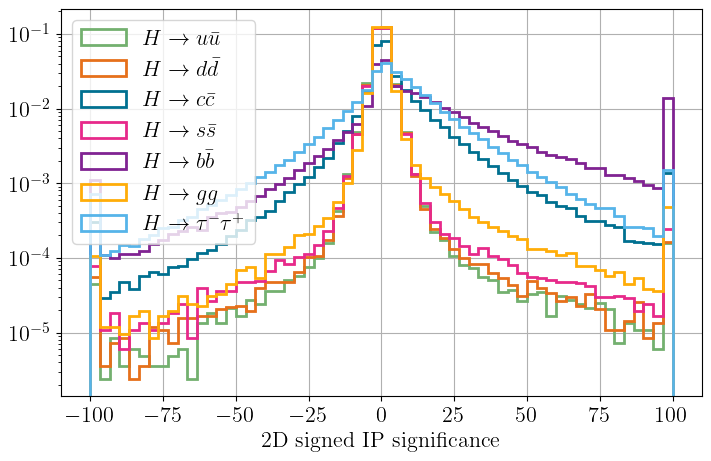

In [30]:
plot_sip2dsig_forNote(save=save_status) # 2m 20s

In [31]:
del dic
gc.collect()

12484

# roc full vs fast sim CLD

In [32]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FullSimCLD_240.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"

In [4]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['Events;1']
    data = tree.arrays(library="np")
    return data

In [5]:
data1 = load_data(path1)
data2 = load_data(path2)

NameError: name 'path1' is not defined

In [5]:
def invalid_ind(data):
    ind = []
    labels = ['G', 'U', 'S', 'C', 'B', 'D', 'TAU']
    for l in labels: 
        true_labels = data[f'recojet_is{l}']
        scores = data[f'score_recojet_is{l}']
        valid_indices = np.where(np.isnan(scores))
        ind.append(valid_indices)
    return np.unique(ind)

In [6]:
# from https://github.com/doloresgarcia/LOGML_2024/blob/81dfa6428bdd6e652908562474cded362d2bf5f6/src/utils/logger_wandb.py#L204 
def create_binary_rocs(positive, negative, y_true, y_score):
    mask_positive = y_true == positive
    if negative == 0 or negative == 1: # merge u and d
        mask_negative = np.logical_or(y_true == 0, y_true == 1)# is that correct???
    else:
        mask_negative = y_true == negative

    number_positive = np.sum(mask_positive)
    number_negative = np.sum(mask_negative)

    if number_positive > 0 and number_negative > 0:
        # Create binary labels for positive and negative classes
        y_true_positive = np.ones(number_positive)
        y_true_negative = np.zeros(number_negative)
        y_true_ = np.concatenate([y_true_positive, y_true_negative])

        # Select scores for positive and negative classes
        y_score_positive = y_score[mask_positive]

        y_score_negative = y_score[mask_negative]
        indices = np.array([negative, positive])
        y_score_selected_positive = y_score_positive[:, indices]
        y_score_selected_negative = y_score_negative[:, indices]

        # Calculate probabilities using softmax
        y_scores_pos_prob = np.exp(y_score_selected_positive) / np.sum(
            np.exp(y_score_selected_positive), axis=1, keepdims=True
        )
        y_scores_neg_prob = np.exp(y_score_selected_negative) / np.sum(
            np.exp(y_score_selected_negative), axis=1, keepdims=True
        )

        # Extract the probability for the positive class
        y_prob_positiveclass = y_scores_pos_prob[:, 1]
        y_prob_positiveclass_neg = y_scores_neg_prob[:, 1]

        # Concatenate probabilities for positive and negative classes
        y_prob_positive = np.concatenate([y_prob_positiveclass, y_prob_positiveclass_neg])

        # Compute ROC curve and AUC score
        fpr, tpr, thrs = roc_curve(y_true_, y_prob_positive, pos_label=1)
        auc_score = roc_auc_score(y_true_, y_prob_positive)

        return [fpr, tpr, auc_score]
    else:
        return []

def log_multiline_rocs_b(y_true, y_score, labels, ax, k,j, ls="solid", l=True):
    q_tag = 4 # b-tagging
    vs_tag = [1,2, 5] # g, u, c
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)


    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        # Calculate TPR for different ROC curves (this function needs to be defined elsewhere)
        #calculate_and_log_tpr_1_10_percent(_bg[0], _bg[1], "b", "g")
        #calculate_and_log_tpr_1_10_percent(_bud[0], _bud[1], "b", "ud")
        #calculate_and_log_tpr_1_10_percent(_bc[0], _bc[1], "b", "c")

        # Plot ROC curves
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k,j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k,j].grid()
        ax[k,j].set_ylim(-3, 0)
        ax[k,j].set_xlabel("jet tagging efficiency")
        ax[k,j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")



In [7]:
def log_multiline_rocs_c(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 2 # b-tagging
    vs_tag = [1,4, 5] # ud, b, g
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0:
        xs = [_bg[1], _bud[1], _bc[1]]
        ys = [_bg[0], _bud[0], _bc[0]]
        auc_ = [_bg[2], _bud[2], _bc[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [8]:
def log_multiline_rocs_s(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 3 # s-tagging
    vs_tag = [1,2, 4, 5] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [9]:
def log_multiline_rocs_g(y_true, y_score, labels, ax, k, j, ls="solid", l=True):
    q_tag = 5 # g-tagging
    vs_tag = [1,2, 3, 4] # ud, b, g
    # colors 
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dic_c = {1: color_cycle[0], 2: color_cycle[1], 3: color_cycle[4], 4: color_cycle[3], 5: color_cycle[2]}
    _bg = create_binary_rocs(q_tag, vs_tag[0], y_true, y_score)
    _bud = create_binary_rocs(q_tag, vs_tag[1], y_true, y_score)
    _bc = create_binary_rocs(q_tag, vs_tag[2], y_true, y_score)
    _bs = create_binary_rocs(q_tag, vs_tag[3], y_true, y_score)

    if len(_bg) > 0 and len(_bud) > 0 and len(_bc) > 0 and len(_bs) > 0:
        xs = [_bg[1], _bud[1], _bc[1], _bs[1]]
        ys = [_bg[0], _bud[0], _bc[0], _bs[0]]
        auc_ = [_bg[2], _bud[2], _bc[2], _bs[2]]

        # plot
        ys_log = [np.log10(j + 1e-8) for j in ys] 
        i = 0
        for x, y in zip(xs, ys_log):
            if l:
                label = f"{labels[q_tag]} vs {labels[vs_tag[i]]}"
            else:
                label=None
            ax[k, j].plot(x, y, label=label, color=dic_c[vs_tag[i]], linestyle=ls) #(AUC={auc_[i]:.3f})")
            i += 1
        ax[k, j].legend(title=f"{labels[q_tag]}-tagging", title_fontproperties={'weight':'bold'})
        ax[k, j].grid()
        ax[k, j].set_ylim(-3, 0)
        ax[k, j].set_xlabel("jet tagging efficiency")
        ax[k, j].set_ylabel("log10(jet misid. probability)")
    else:
        print("failed")

In [10]:
def get_y_true_and_score(data):
    labels = ['U', 'D', 'C', 'S', 'B', 'G', 'TAU']
    y_true = np.array([data[f'recojet_is{label}'] for label in labels])
    y_true = np.argmax(y_true.T, axis=1)
    y_score = np.array([data[f'score_recojet_is{label}'] for label in labels])
    #print(y_score.shape)
    ind_nan = invalid_ind(data)
    #print(ind_nan.shape)
    y_score = np.delete(y_score, ind_nan, axis=1)
    y_true = np.delete(y_true, ind_nan)
    return y_true, y_score.T

In [11]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label='FullSim CLD')
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label='FastSim CLD')

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.6, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FullvsFastSimCLD240.pdf")
    plt.show()

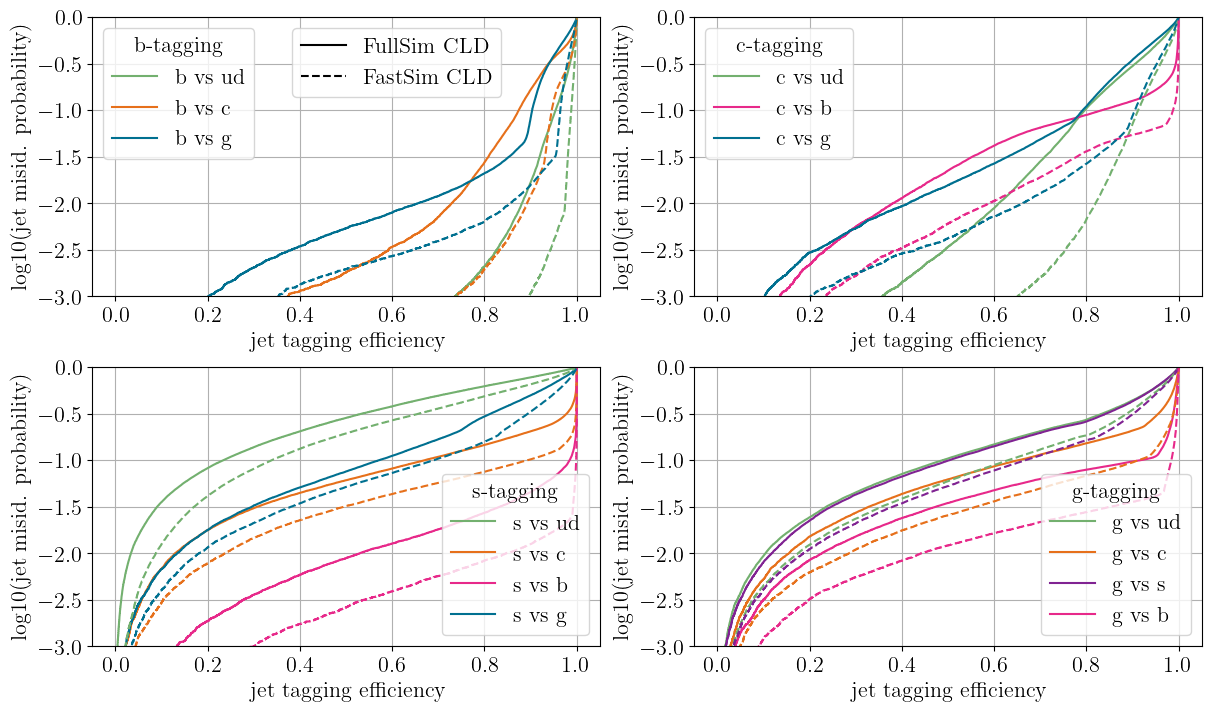

In [42]:
all_rocs(save=save_status)

In [43]:
del data2
gc.collect()

18287

# roc full tc

In [44]:
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FullSimCLD240_tcmatch.root"
data2 = load_data(path2)

In [45]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label='FullSim CLD')
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label='track-based FullSim CLD')

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.65, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FullSimCLD240_vs_tcmatch.pdf")
    plt.show()

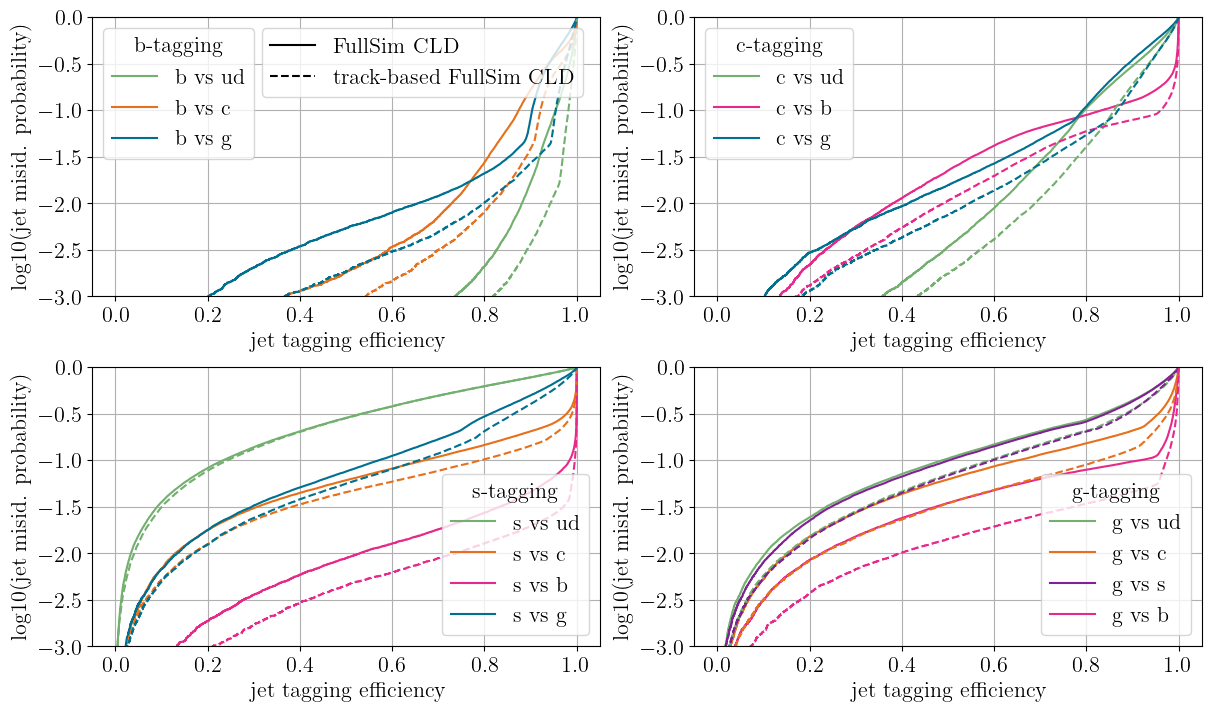

In [46]:
all_rocs(save=save_status)

# roc fast sim vs full sim track-based

In [47]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
data1 = load_data(path1)
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FullSimCLD240_tcmatch.root"
data2 = load_data(path2)

In [48]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label='FastSim CLD')
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label='track-based FullSim CLD')

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.65, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FastSimCLD240_vs_FullSimCLDtcmatch.pdf")
    plt.show()

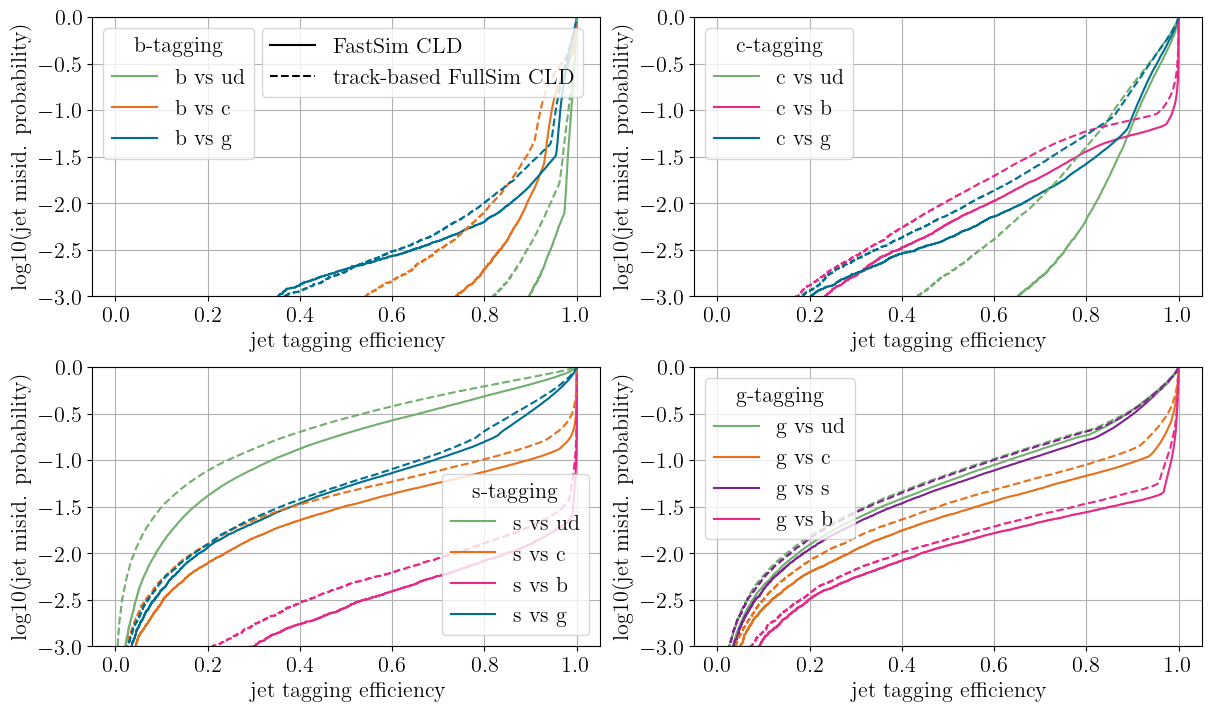

In [49]:
all_rocs(save=save_status)

In [50]:
del data2, data1
gc.collect()

36340

# roc full sim vertex

In [51]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/FullSimCLD_240.root"
data1 = load_data(path1)
#path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/Vs.root"
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fullsimCLD240_Vs.root"
data2 = load_data(path2)

In [52]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label='FullSim CLD')
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label='added vertex info')

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.65, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FullSimCLD240-vs-Vs.pdf")
    plt.show()

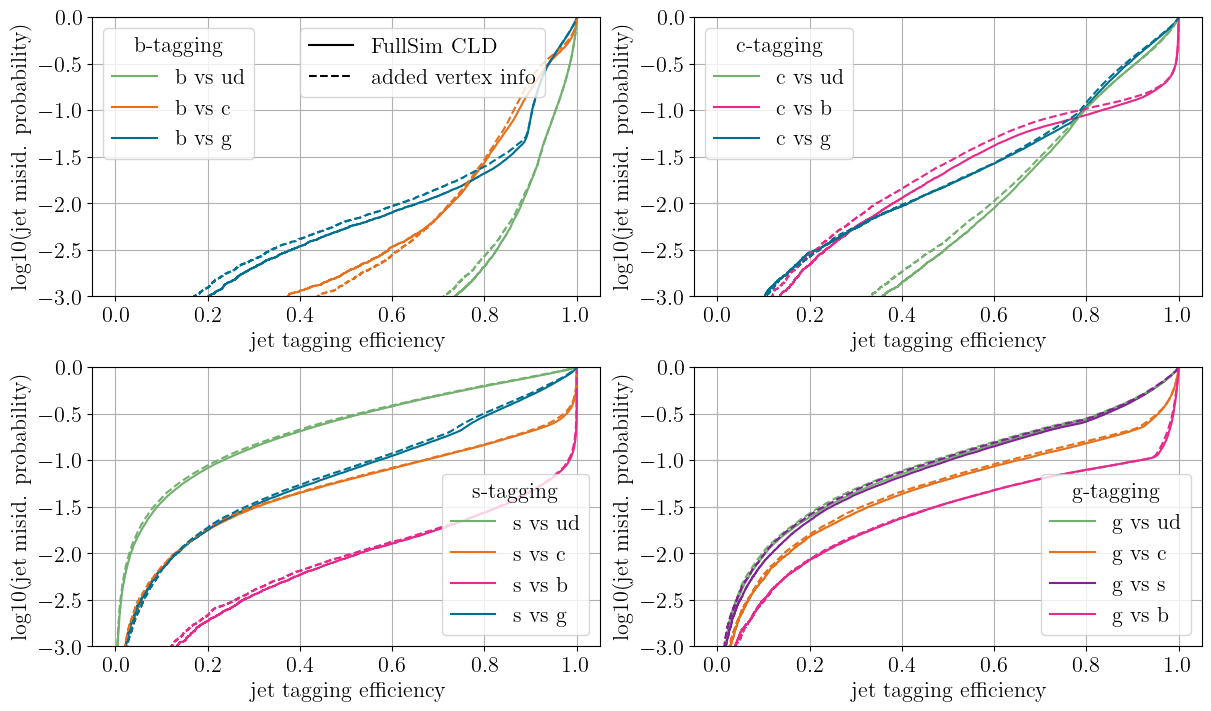

In [53]:
all_rocs(save=save_status)

In [54]:
del data1, data2
gc.collect()

18331

# roc fast sim IDEA vs CLD

In [11]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimCLD240_t2.root"
data1 = load_data(path1)
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimIDEA240_2mio.root"
data2 = load_data(path2)

In [12]:
def all_rocs(save=False):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label='FastSim CLD')
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label='FastSim IDEA')

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.65, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FastSim240CLD_vs_IDEA.pdf")
    plt.show()

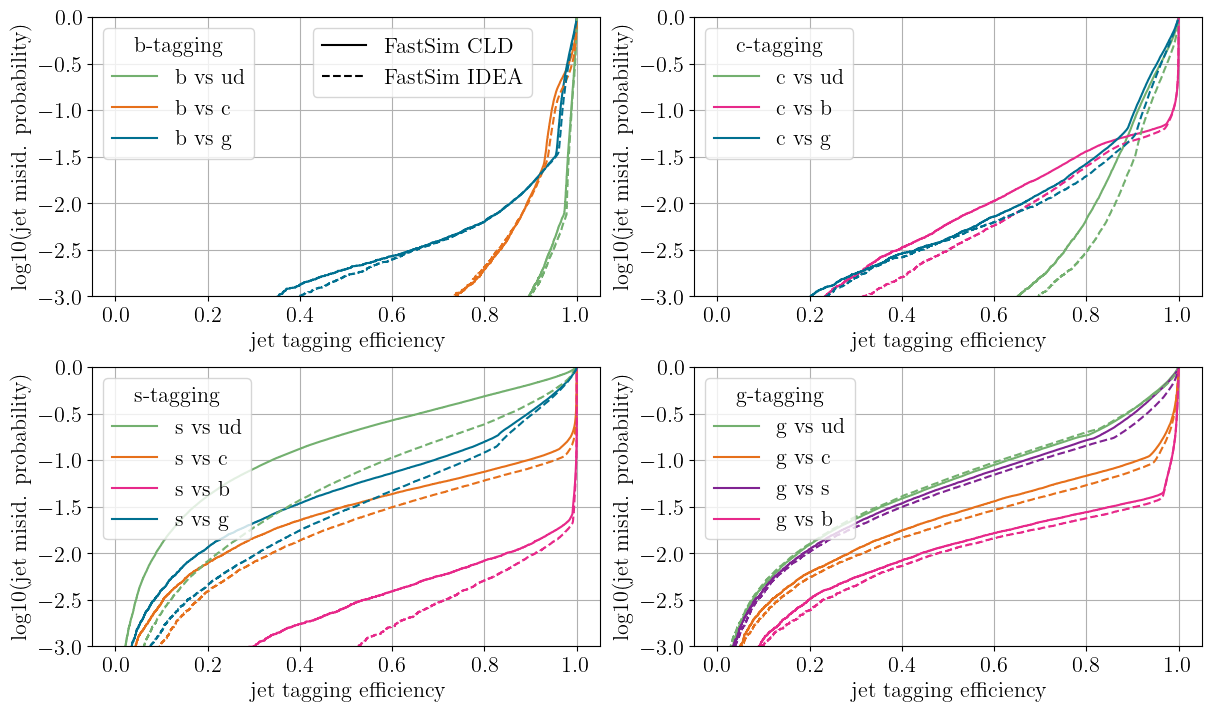

In [15]:
all_rocs(save=save_status)

In [58]:
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimIDEA240_fromAndrea.root"
data2 = load_data(path2)

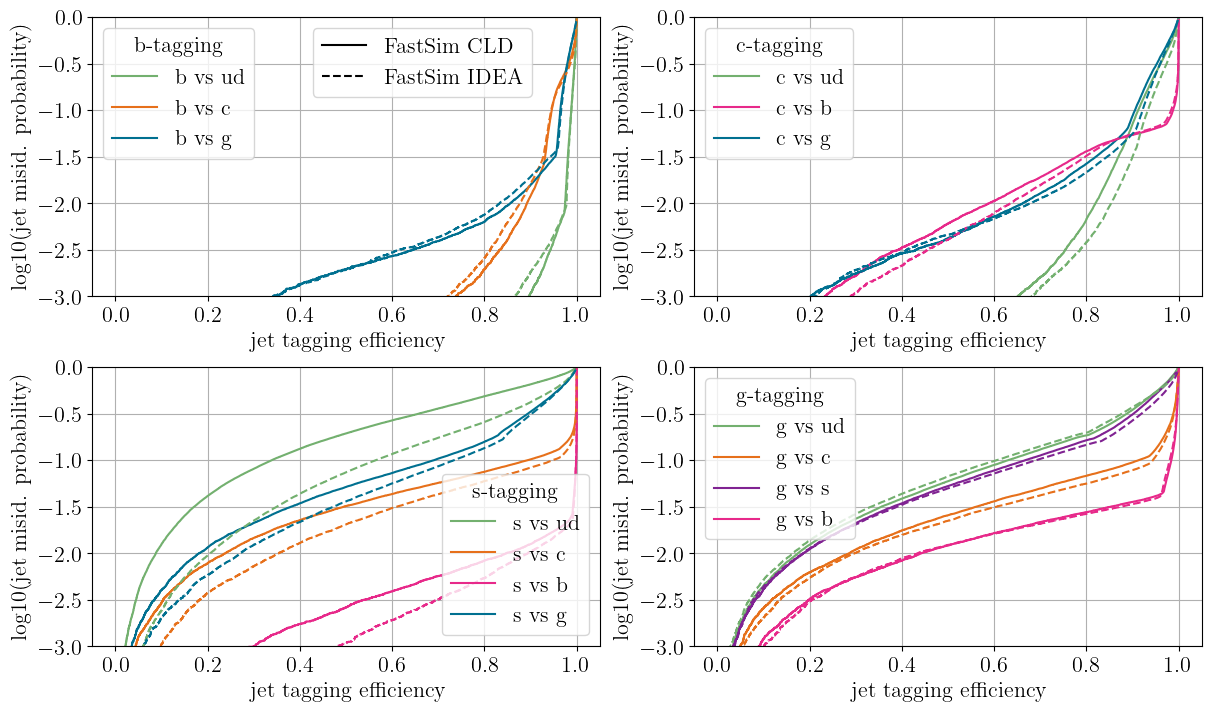

In [59]:
all_rocs()

# roc IDEA 2 mio jets vs 10 mio jets

In [15]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimIDEA240_2mio.root"
data1 = load_data(path1)
path2 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimIDEA240_10mioAndrea.root"
data2 = load_data(path2)

In [20]:
def all_rocs(save=False, label1="data 1", label2="data 2"):
    labels = ['ud', 'ud', 'c', 's', 'b', 'g', 'tau']
    fig, ax = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)
    y_true, y_score = get_y_true_and_score(data1)


    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1)

    y_true, y_score = get_y_true_and_score(data2)

    # Plot ROC curves for tagging
    log_multiline_rocs_b(y_true, y_score, labels, ax, 0, 0, ls="dashed", l=False)
    log_multiline_rocs_c(y_true, y_score, labels, ax, 0, 1, ls="dashed", l=False)
    log_multiline_rocs_s(y_true, y_score, labels, ax, 1, 0, ls="dashed", l=False)
    log_multiline_rocs_g(y_true, y_score, labels, ax, 1, 1, ls="dashed", l=False)


    # Create the first legend for colorful ROC curves
    handles_colorful, labels_colorful = ax[0,0].get_legend_handles_labels()
    legend_colorful = ax[0,0].legend(handles=handles_colorful, title=f"{labels[4]}-tagging", title_fontproperties={'weight':'bold'})

    # Create black lines for FullSim and FastSim
    fullsim_line = Line2D([0], [0], color='black', linestyle='-', label=label1)
    fastsim_line = Line2D([0], [0], color='black', linestyle='--', label=label2)

    # Add the second legend for FullSim and FastSim
    legend_sim = ax[0,0].legend(handles=[fullsim_line, fastsim_line], loc="upper center", bbox_to_anchor=(0.65, 1.0))

    # Add back the first legend (colorful ROC curves) to the plot
    ax[0,0].add_artist(legend_colorful)
    # Re-enable the grid for all subplots
    for row in range(2):
        for col in range(2):
            ax[row, col].grid(True)  # Make sure the grid is visible
    
    if save:
        plt.savefig("./plots-for-FCC-note/roc-FastSim240CLD_vs_IDEA.pdf")
    plt.show()

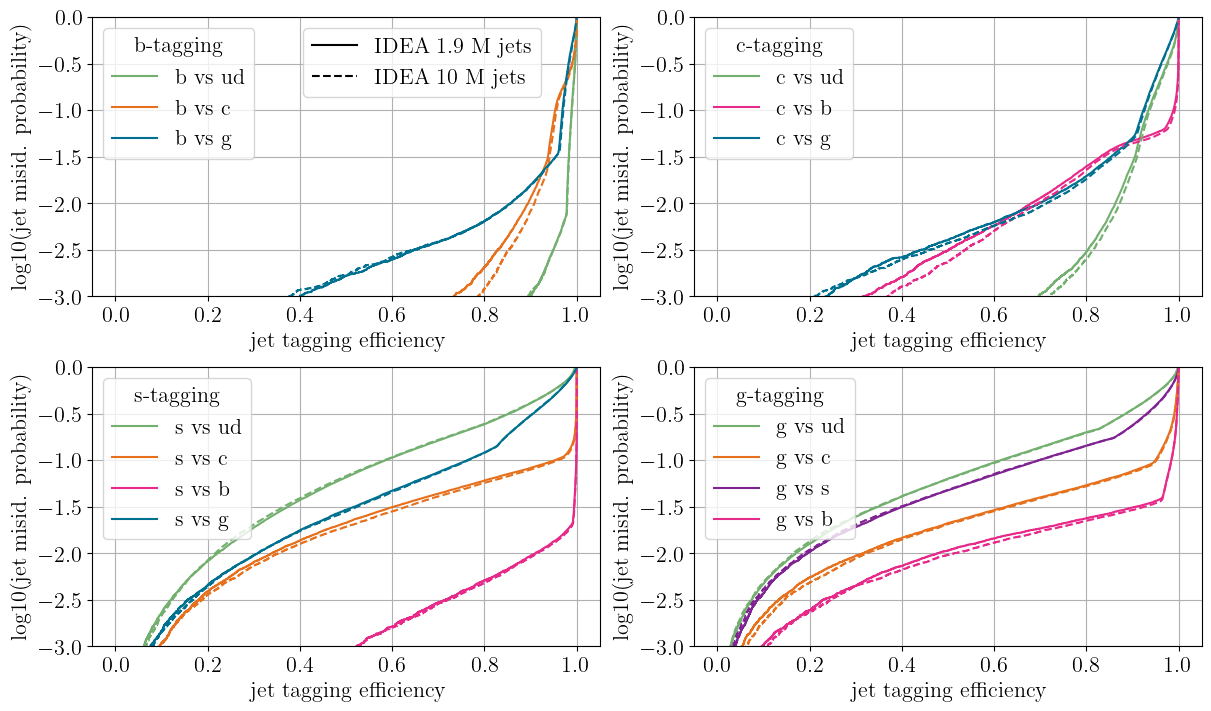

In [17]:
all_rocs(save=save_status, label1="IDEA 1.9 M jets", label2="IDEA 10 M jets")

In [18]:
path1 = "/afs/cern.ch/work/s/saaumill/public/tagging_performance/fastsimIDEA240_fromAndrea.root"
data1 = load_data(path1)

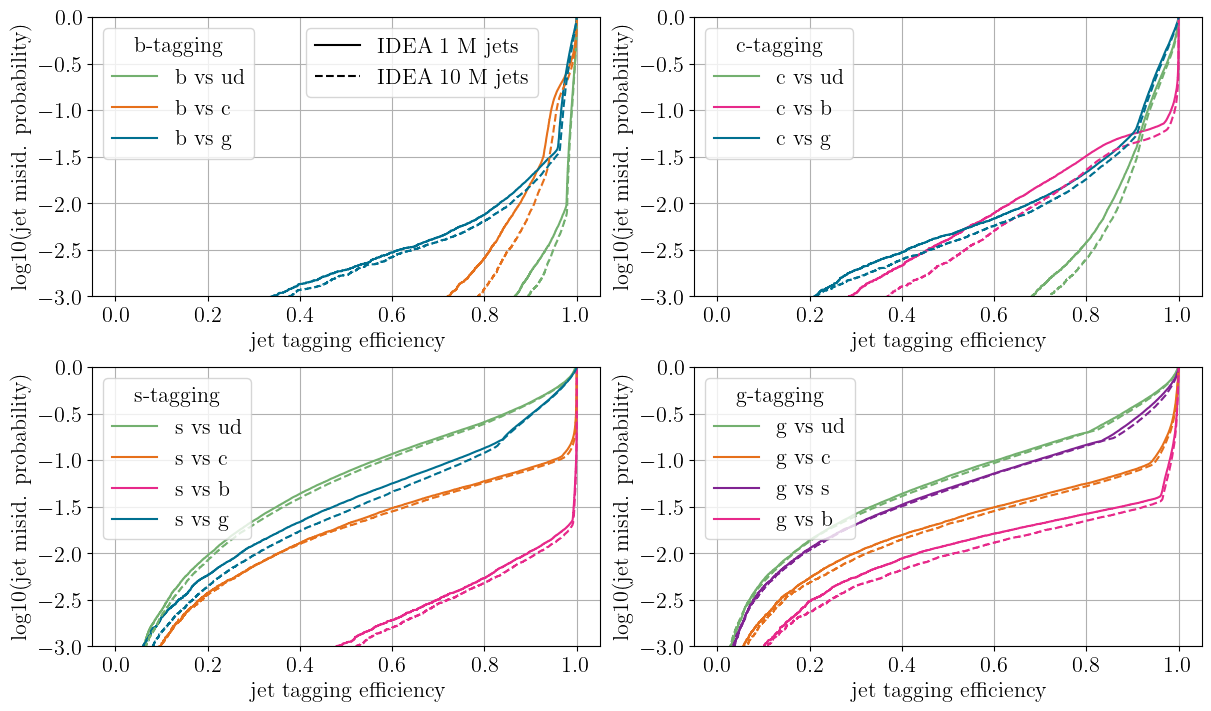

In [22]:
all_rocs(save=save_status, label1="IDEA 1 M jets", label2="IDEA 10 M jets")

# vertex info plots 

(might load long)

In [60]:
def load_data(file_name):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=250000) # 250k takes 9min to load
    return data

In [61]:
path = "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_Vs/hadded"
dic = {
    "uu": np.array([]),
    "dd": np.array([]),
    "ss": np.array([]),
    "cc": np.array([]),
    "bb": np.array([]),
    "gg": np.array([]),
    "tautau": np.array([])
}

for process in dic.keys():
    data = load_data(f"{path}/H{process}.root")
    dic[process] = data

# 13 min on fcc03 ironic

In [64]:
def make_vertex_dic(htype, type):
    data = dic[htype]
    ids = np.concatenate(data[f"pfcand_{type}_id"])
    x = np.concatenate(data[f"pfcand_{type}_x"])
    y = np.concatenate(data[f"pfcand_{type}_y"])
    z = np.concatenate(data[f"pfcand_{type}_z"])
    M = np.concatenate(data[f"pfcand_{type}_M"])
    ind_unique = np.unique(ids, return_index=True)[1]
    ind_unique = ind_unique[1:] # remove the first element which is zero
    vertex_dic = {"x": x[ind_unique], "y": y[ind_unique], "z": z[ind_unique], "M": M[ind_unique]}
    return vertex_dic
    

In [65]:
dic_V0 = {}
dic_SV = {}

for key in dic.keys():
    dic_V0[key] = make_vertex_dic(key, "V0")
    dic_SV[key] = make_vertex_dic(key, "SV")


In [66]:
def joint_plot(save=False):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)
    labels = [r'$ H \rightarrow u \bar{u}$', r'$ H \rightarrow d \bar{d}$', r'$ H \rightarrow c \bar{c}$', r'$ H \rightarrow s \bar{s}$', r'$ H \rightarrow b \bar{b}$', r'$ H \rightarrow g g$', r'$ H \rightarrow \tau^- \tau^+$']

    pid_color = "black"
    bins= 60

    text_offset = 0.05


    # V0 
    for i, h in enumerate(dic.keys()):
        ax[0].hist(dic_V0[h]["M"], bins=bins, histtype='step', linewidth=2.0, range=[0.4, 0.55], label=labels[i])
    ax[0].set_title(r"V$^0$ vertices")
    ax[0].grid()
    ax[0].set_xlabel("$m$ (GeV)")
    ax[0].axvline(0.4976 , color=pid_color, linestyle="--")
    ax[0].text(0.4976- 0.005, ax[0].get_ylim()[1] * 0.9, r"$K^0$", color=pid_color, ha='right', fontsize=14)
    ax[0].legend(loc='upper left')

    # SV
    for i, k in enumerate(dic.keys()):
        r2 = np.sqrt(dic_SV[k]["x"]**2 + dic_SV[k]["y"]**2)
        ax[1].hist(r2, bins=bins, histtype='step', linewidth=2.0, range=[0, 40], density=True)
        ax[1].set_yscale("log")
    ax[1].set_title("secondary vertices")
    ax[1].set_xlabel(r"$r = \sqrt{x^2 + y^2}$ (mm)")
    ax[1].grid()
    #ax[1].legend(loc="upper right")

    if save:
        plt.savefig('./plots-for-FCC-note/fullSimCLD-Vinfo_joined.pdf')
    plt.show()
    

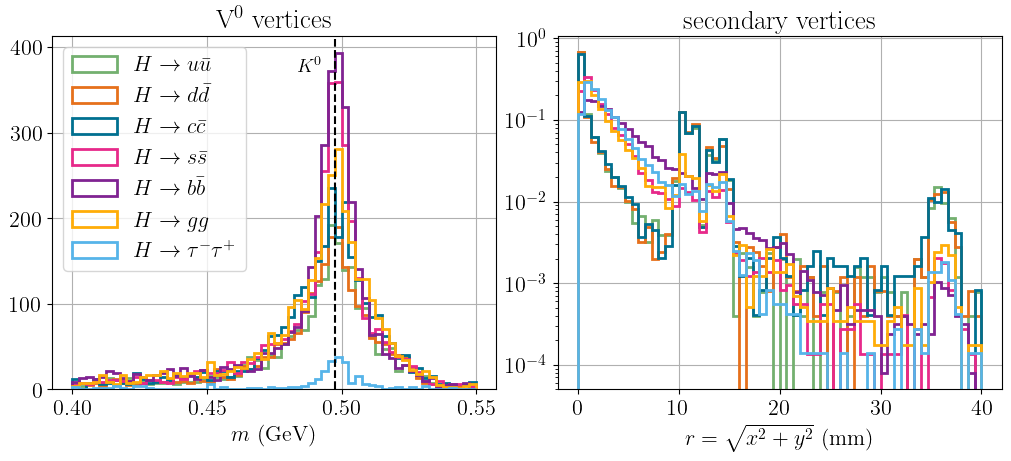

In [67]:
joint_plot(save=save_status)

In [ ]:
# check colors 

plt.rc('axes', prop_cycle=cycler('color', [
    '#73b06f',  # green (keep)
    '#e6701b',  # orange (keep)
    '#0072b2',  # blue
    '#d55e00',  # dark orange/red
    '#cc79a7',  # magenta
    '#f0e442',  # yellow
    '#56b4e9',  # light blue (already in your list)
]))

In [ ]:
plt.style.use('default')

In [ ]:
plt.rc('axes', prop_cycle=cycler('color', [
    '#73b06f',  # green (keep)
    '#e6701b',  # orange (keep)
    '#0072b2',  # blue (darker)
    '#d95f02',  # burnt orange
    '#1b9e77',  # teal
    '#e7298a',  # pink
    '#66a61e',  # olive green
]))

In [ ]:
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))
#plt.rc('axes', prop_cycle=cycler('color', ['#7ba975', '#d1a33b', '#00688f', '#d78397', '#785795', '#f2ac2b', '#5ba1d8'])) # red blind
#plt.rc('axes', prop_cycle=cycler('color', ['#7ea57a', '#d1a43c', '#00688f', '#d38497', '#775897', '#f2ac2b', '#5aa2da'])) # green blind
#plt.rc('axes', prop_cycle=cycler('color', ['#78a76c', '#e56a46', '#546f72', '#df4c7a', '#92558c', '#de7d16', '#7fa5c9'])) # blue blind



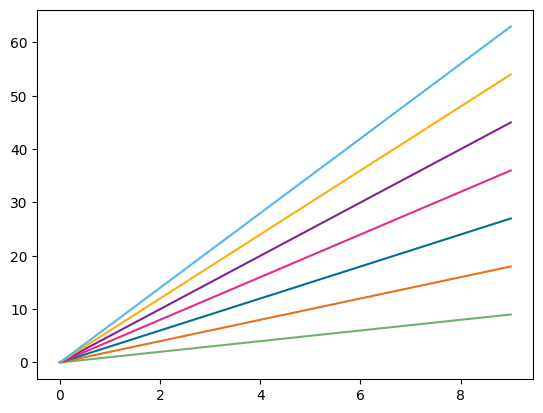

In [ ]:
a = np.arange(7)+1
for i in range(7):
    plt.plot(np.arange(10)*a[i])

plt.show()